In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load M5 dataset
data_path = Path("../data/raw")

# Load main files
sales = pd.read_csv(data_path / "sales_train_validation.csv")
calendar = pd.read_csv(data_path / "calendar.csv")
prices = pd.read_csv(data_path / "sell_prices.csv")

print(f"Sales shape: {sales.shape}")
print(f"Calendar shape: {calendar.shape}")
print(f"Prices shape: {prices.shape}")

Sales shape: (30490, 1919)
Calendar shape: (1969, 14)
Prices shape: (6841121, 4)


In [6]:
# Transform to long format
day_cols = [col for col in sales.columns if col.startswith('d_')]
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

# Melt sales data
sales_long = sales.melt(
    id_vars=id_cols,
    value_vars=day_cols,
    var_name='d',
    value_name='sales'
)

# Merge with calendar to get dates
sales_long = sales_long.merge(calendar[['d', 'date', 'wm_yr_wk']], on='d', how='left')
sales_long['date'] = pd.to_datetime(sales_long['date'])

print(f"Sales long format shape: {sales_long.shape}")
print(sales_long.head())

Sales long format shape: (58327370, 10)
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  sales       date  wm_yr_wk  
0       CA  d_1      0 2011-01-29     11101  
1       CA  d_1      0 2011-01-29     11101  
2       CA  d_1      0 2011-01-29     11101  
3       CA  d_1      0 2011-01-29     11101  
4       CA  d_1      0 2011-01-29     11101  


In [9]:
# Basic statistics
print(f"Date range: {sales_long['date'].min()} to {sales_long['date'].max()}")
print(f"\nTotal unique items: {sales_long['item_id'].nunique()}")
print(f"Total unique stores: {sales_long['store_id'].nunique()}")
print(f"Total unique time series: {sales_long['id'].nunique()}")
print(f"\nCategories: {sales_long['cat_id'].unique()}")
print(f"States: {sales_long['state_id'].unique()}")

Date range: 2011-01-29 00:00:00 to 2016-04-24 00:00:00

Total unique items: 3049
Total unique stores: 10
Total unique time series: 30490

Categories: ['HOBBIES' 'HOUSEHOLD' 'FOODS']
States: ['CA' 'TX' 'WI']


Average zero rate across all series: 68.20%
Series with >50% zeros: 23916 out of 30490
Series with >80% zeros: 11783


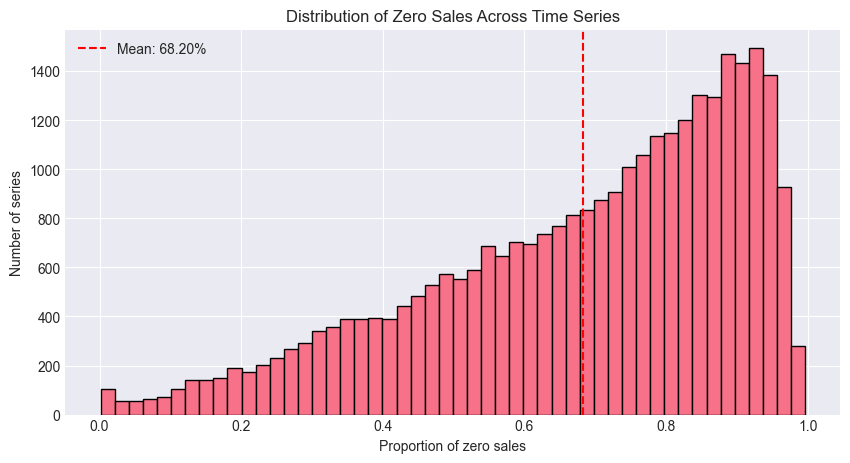

In [10]:
# Analyze intermittent demand (zero sales)
zero_rate = (sales_long.groupby('id')['sales']
             .apply(lambda x: (x == 0).sum() / len(x))
             .sort_values(ascending=False))

print(f"Average zero rate across all series: {zero_rate.mean():.2%}")
print(f"Series with >50% zeros: {(zero_rate > 0.5).sum()} out of {len(zero_rate)}")
print(f"Series with >80% zeros: {(zero_rate > 0.8).sum()}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(zero_rate, bins=50, edgecolor='black')
plt.xlabel('Proportion of zero sales')
plt.ylabel('Number of series')
plt.title('Distribution of Zero Sales Across Time Series')
plt.axvline(zero_rate.mean(), color='red', linestyle='--', label=f'Mean: {zero_rate.mean():.2%}')
plt.legend()
plt.show()

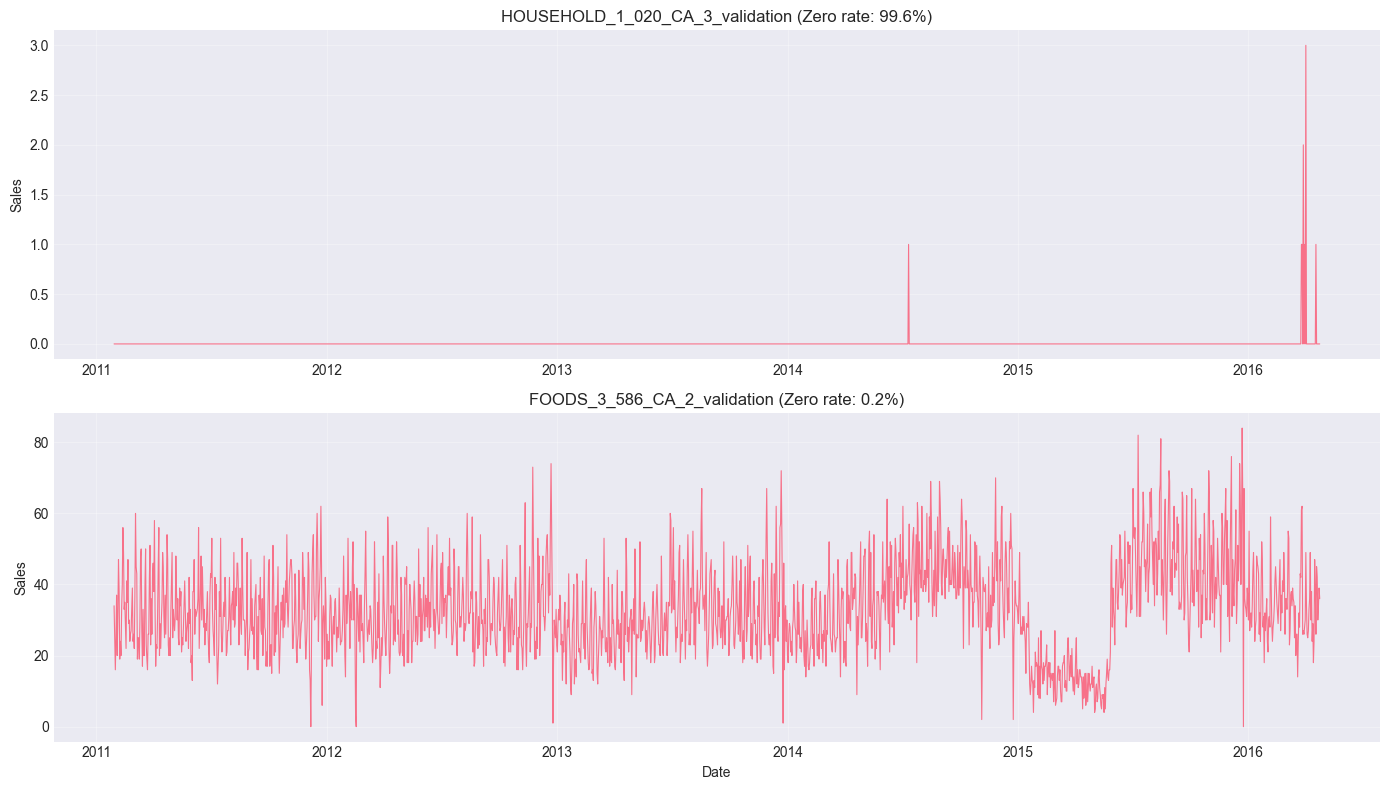

In [11]:
# Select example series: one highly intermittent, one regular
intermittent_id = zero_rate.head(1).index[0]  # Most intermittent
regular_id = zero_rate.tail(1).index[0]  # Least intermittent

# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for idx, (series_id, ax) in enumerate(zip([intermittent_id, regular_id], axes)):
    data = sales_long[sales_long['id'] == series_id].sort_values('date')
    ax.plot(data['date'], data['sales'], linewidth=0.8)
    ax.set_title(f'{series_id} (Zero rate: {zero_rate[series_id]:.1%})')
    ax.set_ylabel('Sales')
    ax.grid(True, alpha=0.3)

axes[1].set_xlabel('Date')
plt.tight_layout()
plt.show()

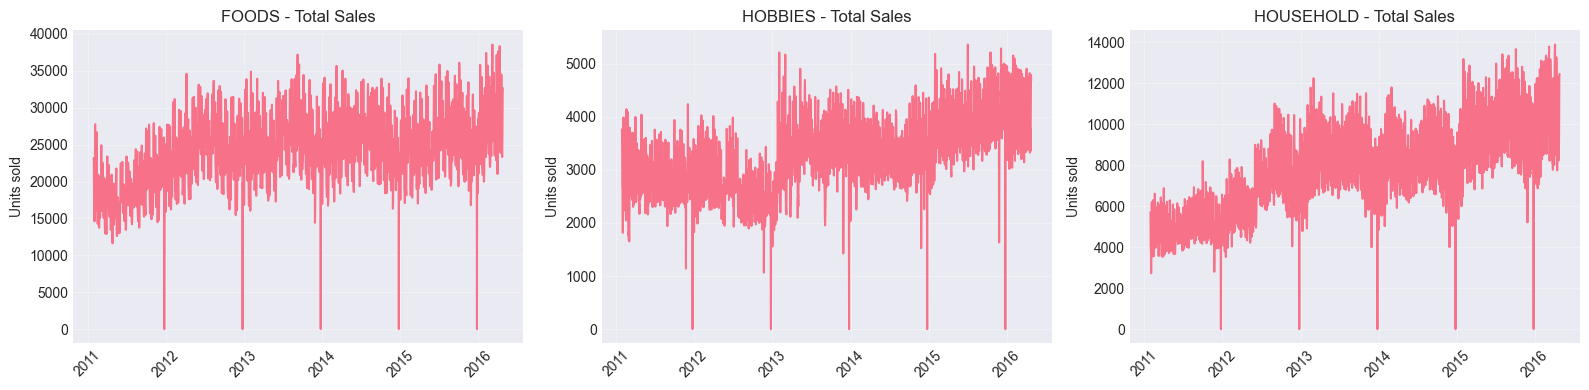


Average daily sales by category:
cat_id
FOODS        7856.758843
HOUSEHOLD    2523.204391
HOBBIES      1067.224255
Name: sales, dtype: float64


In [12]:
# Aggregate sales by category and state
agg_sales = (sales_long.groupby(['date', 'cat_id', 'state_id'])['sales']
             .sum()
             .reset_index())

# Plot sales by category
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for idx, cat in enumerate(['FOODS', 'HOBBIES', 'HOUSEHOLD']):
    cat_data = agg_sales[agg_sales['cat_id'] == cat].groupby('date')['sales'].sum()
    axes[idx].plot(cat_data.index, cat_data.values)
    axes[idx].set_title(f'{cat} - Total Sales')
    axes[idx].set_ylabel('Units sold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nAverage daily sales by category:")
print(agg_sales.groupby('cat_id')['sales'].mean().sort_values(ascending=False))

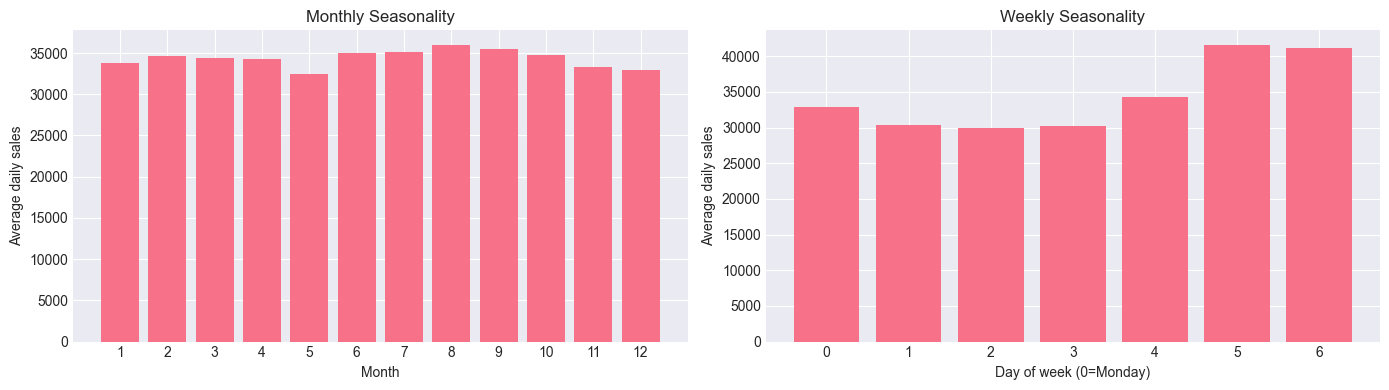

In [13]:
# Seasonality analysis - aggregate all series
total_sales = sales_long.groupby('date')['sales'].sum().reset_index()
total_sales['year'] = total_sales['date'].dt.year
total_sales['month'] = total_sales['date'].dt.month
total_sales['dayofweek'] = total_sales['date'].dt.dayofweek

# Monthly seasonality
monthly = total_sales.groupby('month')['sales'].mean()

# Weekly seasonality
weekly = total_sales.groupby('dayofweek')['sales'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Monthly pattern
axes[0].bar(monthly.index, monthly.values)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Average daily sales')
axes[0].set_title('Monthly Seasonality')
axes[0].set_xticks(range(1, 13))

# Weekly pattern
axes[1].bar(weekly.index, weekly.values)
axes[1].set_xlabel('Day of week (0=Monday)')
axes[1].set_ylabel('Average daily sales')
axes[1].set_title('Weekly Seasonality')
axes[1].set_xticks(range(7))

plt.tight_layout()
plt.show()

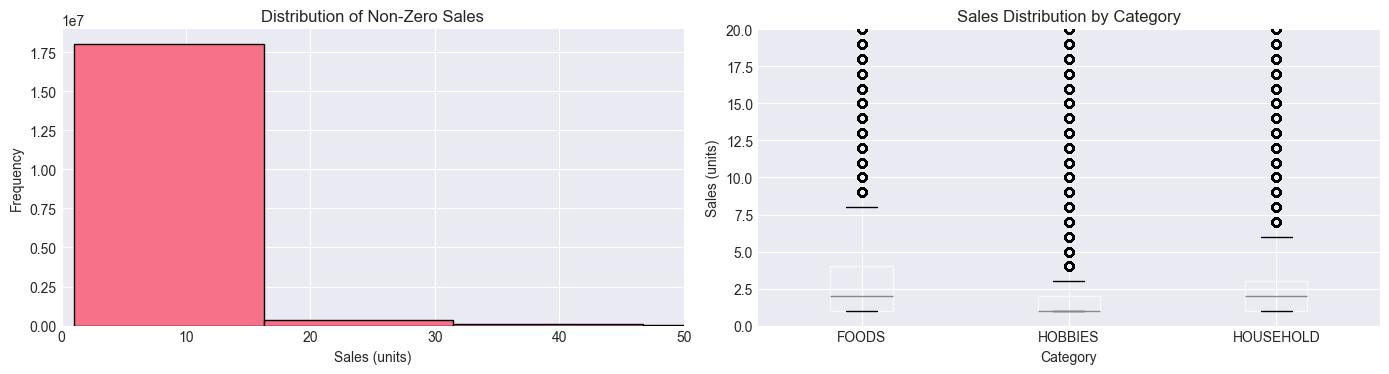


Non-zero sales statistics:
count    1.855028e+07
mean     3.541479e+00
std      6.214025e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      7.630000e+02
Name: sales, dtype: float64


In [17]:
# Sales distribution
non_zero_sales = sales_long[sales_long['sales'] > 0]['sales']

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram
axes[0].hist(non_zero_sales, bins=50, edgecolor='black')
axes[0].set_xlabel('Sales (units)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Non-Zero Sales')
axes[0].set_xlim(0, 50)

# Box plot by category
sales_long[sales_long['sales'] > 0].boxplot(column='sales', by='cat_id', ax=axes[1])
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Sales (units)')
axes[1].set_title('Sales Distribution by Category')
axes[1].set_ylim(0, 20)
plt.suptitle('')

plt.tight_layout()
plt.show()

print(f"\nNon-zero sales statistics:")
print(non_zero_sales.describe())


In [18]:
# Save some processed data for next steps
print("=== SUMMARY ANALISI ESPLORATIVA ===\n")
print(f"📊 Dataset: {sales_long['id'].nunique()} serie temporali")
print(f"📅 Periodo: {sales_long['date'].min()} - {sales_long['date'].max()}")
print(f"🏪 Negozi: {sales_long['store_id'].nunique()} in {sales_long['state_id'].nunique()} stati")
print(f"📦 Prodotti: {sales_long['item_id'].nunique()}")
print(f"\n⚠️ INTERMITTENZA:")
print(f"  - Media zeri: {zero_rate.mean():.1%}")
print(f"  - Serie con >50% zeri: {(zero_rate > 0.5).sum()} ({(zero_rate > 0.5).sum()/len(zero_rate)*100:.1f}%)")
print(f"  - Serie con >80% zeri: {(zero_rate > 0.8).sum()} ({(zero_rate > 0.8).sum()/len(zero_rate)*100:.1f}%)")
print(f"\n💰 VENDITE (non-zero):")
print(f"  - Media: {non_zero_sales.mean():.2f} unità")
print(f"  - Mediana: {non_zero_sales.median():.2f} unità")
print(f"  - Max: {non_zero_sales.max():.0f} unità")

# Save zero_rate for later use
zero_rate.to_csv('../data/processed/zero_rate.csv')
print("\n✅ Zero rate salvato in data/processed/")

=== SUMMARY ANALISI ESPLORATIVA ===

📊 Dataset: 30490 serie temporali
📅 Periodo: 2011-01-29 00:00:00 - 2016-04-24 00:00:00
🏪 Negozi: 10 in 3 stati
📦 Prodotti: 3049

⚠️ INTERMITTENZA:
  - Media zeri: 68.2%
  - Serie con >50% zeri: 23916 (78.4%)
  - Serie con >80% zeri: 11783 (38.6%)

💰 VENDITE (non-zero):
  - Media: 3.54 unità
  - Mediana: 2.00 unità
  - Max: 763 unità

✅ Zero rate salvato in data/processed/
